In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A

# from ipywidgets import IntProgress
import multiprocessing
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

In [2]:
def plot_image(image, boxes, labels, scores):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(10,10))
    
    for box,label, score in zip(boxes, labels, scores):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 1)
        label = categories[label]['name'].upper() + " " + str(score)
        print(label)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX_SMALL, 
                    fontScale = 0.5,
                    color = (255, 0, 0),
                    thickness = 1,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)
    
def plot_healhty_image(image):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(10,10))

    plt.imshow(image)

In [3]:
def get_abnormal_boxes(idx, df):
    
    records = df.loc[idx]
    image_id = records['image_id']

    img_path = 'train_2x/train/' + image_id + '.jpg'
     
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
    boxes = np.array(boxes.tolist()).T
    boxes = boxes.astype(int)
    
    print(image.shape)
    cuts = []
    for box in boxes:
        xmin = box[0]
        ymin = box[1]
        xmax = box[2]
        ymax = box[3]
        
        cut = image[ymin:ymax, xmin:xmax].copy()
        coords = (xmin, ymin, xmax, ymax)
        cuts.append((cut, coords))
    
    labels = records['class_id']
    scores = np.ones(len(labels))
    
    return image, boxes, labels, scores, cuts


def load_image(idx, df):
    
    records = df.loc[idx]
    image_id = records['image_id']

    img_path = 'train_2x/train/' + image_id + '.jpg'
     
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1440, 1152, 3)
ILD 1.0
ILD 1.0
AORTIC ENLARGEMENT 1.0
CARDIOMEGALY 1.0
PLEURAL THICKENING 1.0
PLEURAL THICKENING 1.0
PLEURAL THICKENING 1.0
PULMONARY FIBROSIS 1.0
PULMONARY FIBROSIS 1.0
PULMONARY FIBROSIS 1.0


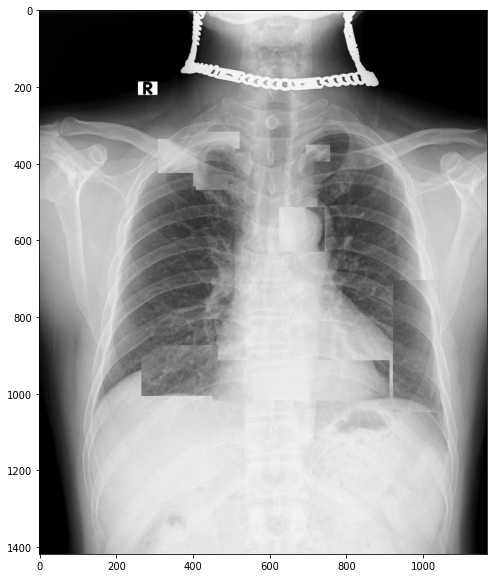

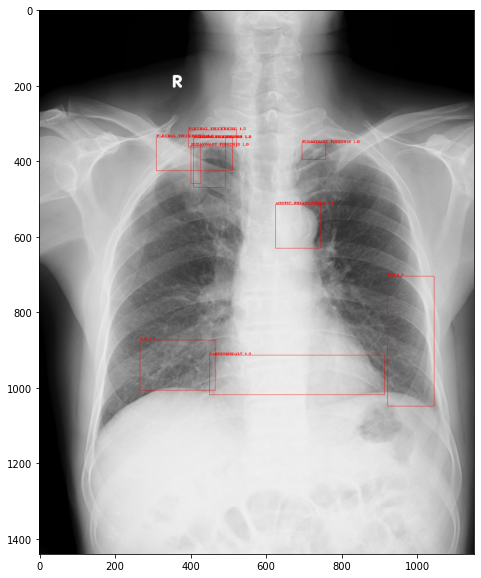

In [5]:

df = pd.read_csv('train_downsampled.csv')
normal_df = df[df.class_id == 14].groupby('image_id').agg(lambda x: list(x)).reset_index()

df = pd.read_csv('10_fold_abnormal.csv')
abnormal_df = df.groupby('image_id').agg(lambda x: list(x)).reset_index()


image, boxes, labels, scores, cuts = get_abnormal_boxes(1, abnormal_df)
healthy = load_image(0, normal_df)

for cut, coord in cuts:
    healthy[coord[1]:coord[3], coord[0]:coord[2]] = cut

plot_healhty_image(healthy)

plot_image(image, boxes, labels, scores)

In [3]:
@PIPELINES.register_module()
class MixUp(object):
    def __init__(self, p=0.3, lambd=0.5):
        self.lambd = lambd
        self.p = p
        self.img2 = None
        self.boxes2 = None
        self.labels2= None

    def __call__(self, results):
        img1, boxes1, labels1 = [
            results[k] for k in ('img', 'gt_bboxes', 'gt_labels')
        ]


        if random.random() < self.p and self.img2 is not None and img1.shape[1]==self.img2.shape[1]:

            height = max(img1.shape[0], self.img2.shape[0])
            width = max(img1.shape[1], self.img2.shape[1])
            mixup_image = np.zeros([height, width, 3], dtype='float32')
            mixup_image[:img1.shape[0], :img1.shape[1], :] = img1.astype('float32') * self.lambd
            mixup_image[:self.img2.shape[0], :self.img2.shape[1], :] += self.img2.astype('float32') * (1. - self.lambd)
            mixup_image = mixup_image.astype('uint8')

            mixup_boxes = np.vstack((boxes1, self.boxes2))
            mixup_label = np.hstack((labels1,self.labels2))
            results['img'] = mixup_image
            results['gt_bboxes'] = mixup_boxes
            results['gt_labels'] = mixup_label
        else:
            pass
        
        self.img2 = img1
        self.boxes2 = boxes1
        self.labels2 =  labels1
        return results

In [ ]:
@PIPELINES.register_module()
class CutMix(object):
    def __init__(self,root_dir='', p=1.0):
        
        self.root_dir = root_dir
        df = df

    def __call__(self, results):
        
        if random.random() < self.p and if len(results['gt_bboxes']) == 0:
            
            r_id = random.randint(self.df.len())
            
            
            records = df.iloc[r_id]
            image_id = records['image_id']
        
            img_path = self.root_dir + image_id + '.png'

            abnormal_image = cv2.imread(img_path)
            abnormal_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             abnormal_image = image / 255
#             abnormal_image = image.astype('float32')

            boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
            boxes = np.array(boxes.tolist()).T

            labels = records['class_id']

            scores = np.ones(len(labels))
            
            original_img = results['img']
            
            for box in boxes:
                
                x_min = box[0]
                y_min = box[1]
                x_max = box[2]
                y_max = box[3]
                
                original_img[x_min:x_max, y_min:y_max] = abnormal_image[x_min:x_max, y_min:y_max]
            
            results['img'] = original_img
            results['gt_bboxes'] = boxes
            results['gt_labels'] = labels
        else:
            pass
        
        self.img2 = img1
        self.boxes2 = boxes1
        self.labels2 =  labels1
        return results